In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator
from datetime import date

# k-means clustering experiment

As a method of feature reduction, we are applying unsupervised clustering to a cleaned and scaled housing attribute dataset. For now, we are sticking with K-means method of clustering. We would like to try the k-medoids method for clustering, but we are currently running into memory issues.

### Version 1

Unsupervised clustering on all of the housing attributes.
The elbow graph recommends running k-mean with a k of 7, which results in an average silhouette score of .222 and intertia of 416779.42977163894.


### Version 2
Unsupervised clustering on all of the housing attributes except 'STORIES', 'TOTALROOMS', 'BEDROOMS', 'FULLBATHS', and 'HALFBATHS'. I choose to do this because those attributes have values less than -1, so I think the scaling maybe throwing the clustering results. 

The elbow graph recommends running k-mean with a k of 8, which results in average silhouette score of 0.4270135465284009 and intertia of 94038.47414996561.


### Silhouette Coefficient
<blockquote source='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score' >
    "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar."
    
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
</blockquote>

### References:

https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html

https://medium.com/analytics-vidhya/supernaive-k-medoids-clustering-31db7bfc5075

https://developers.google.com/machine-learning/clustering/interpret

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

https://harvard-iacs.github.io/2019-CS109B/labs/lab7/solutions/

In [2]:
pd.set_option("display.max_columns", 999)
parcel_df = pd.read_csv('house_attributes.csv', index_col=0)
parcel_df.head(3)

,CONDO HR,MULTI-FAMILY,ROW END,ROW INTERIOR,OLD STYLE,SEMI DETACHED,CONDO,BI-LEVEL,SPLIT LEVEL,COLONIAL,TOWNHOUSE,CONDO CONV,CONDO INT,TUDOR,VICTORIAN,RANCH,CONDO GRDN,CONDO END,CAPE COD,BUNGALOW,CONTEMPORARY,MANUFACTURED,MODULAR HOME,LOG CABIN,CONDO PAT/CARG,CONVENTIONAL,OTHER,CONDO SINGLE,ROLL,SHINGLE,RUBBER,SLATE,TILE,METAL,Concrete,Brick,Stone,Concrete Block,Masonry FRAME,Frame,Stucco,Log,None,Part,Full,Slab/Piers,Crawl,STORIES,TOTALROOMS,BEDROOMS,FULLBATHS,HALFBATHS
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.264172,-2.140282,-1.237946,0.782665,-0.947308
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.264172,-2.140282,-2.394149,-0.763327,0.796003
70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.264172,-0.934785,-0.081743,0.782665,-0.947308


In [3]:
parcel_df.shape

(143665, 52)

In [4]:
def create_elbow_plot(cluster_range, inertia_values):
    # from allegheny_county_property_assessments_eda
    # Converting the results into a dataframe and plotting them
    NumClusters  =[*cluster_range]
    frame = pd.DataFrame({'Cluster': cluster_range, 'inertia_values':inertia_values})
    plt.figure(figsize=(12,6))
    plt.plot(frame['Cluster'], frame['inertia_values'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    kneedle = KneeLocator(NumClusters, inertia_values, curve='convex', direction='decreasing')
    cluster_count = kneedle.elbow
    
    plt.vlines([cluster_count], ymin=min(inertia_values), ymax=max(inertia_values))
    plt.plot()
    plt.show()

In [5]:
# Output:
# tuple of cardinality and cluster assignments for each loop

n_range = range(2,21)
def run_kmeans_clustering(data):
    inertias = []
    cluster_cardinalities = []
    cluster_centers = []
    cluster_assignments = []
    for cluster_number in n_range:
        kmeans = KMeans(init='k-means++', n_clusters=cluster_number)
        clusters = kmeans.fit_predict(data) 

        print("")
        print("K-means: ", kmeans)
        # Record the inertia value
        inertias.append(kmeans.inertia_)
        
        # Record cluster centers, create data frame
        cluster_centers.append(kmeans.cluster_centers_)     
        cluster_assignments.append(clusters)
        
        # Record number of assignments to each label
        cardinality = np.unique(cluster_assignments, return_counts=True)
        cluster_cardinality_df = pd.DataFrame(data={
            'labels': cardinality[0],
            'frequency': cardinality[1],
        })
        cluster_cardinalities.append(cluster_cardinality_df)
        
        print(cluster_cardinality_df)
        print("")
        
        average_silhouette_score = silhouette_score(data, clusters)
#         silhouette_values = silhouette_samples(data, clusters, metric='euclidean')
        print("average_silhouette_score: ", average_silhouette_score)
        print("-----------------------------------------------------")
        print("")
        print("")

        
    return (cluster_cardinalities, inertias, cluster_assignments)

In [6]:
kmeans_clustering_data = run_kmeans_clustering(parcel_df)


K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   labels  frequency
0       0      44151
1       1      99514

average_silhouette_score:  0.2619535470523335
-----------------------------------------------------



K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   labels  frequency
0       0      99606
1       1     138342
2       2      49382

average_silhouette_score:  0.21980764331640681
-----------------------------------------------------



K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   labels  frequency
0       0    

average_silhouette_score:  0.20049942977537905
-----------------------------------------------------



K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
    labels  frequency
0        0     342941
1        1     422063
2        2     301886
3        3     265686
4        4     203933
5        5     186530
6        6     180560
7        7     118433
8        8      79110
9        9      97690
10      10      64872
11      11      62950
12      12      24603
13      13      40932
14      14      17927
15      15      19672
16      16       9549
17      17       2968

average_silhouette_score:  0.2073287724648136
-----------------------------------------------------



K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=19, n_init=10, n_jobs=None, precompute_distances='auto',
       random_s

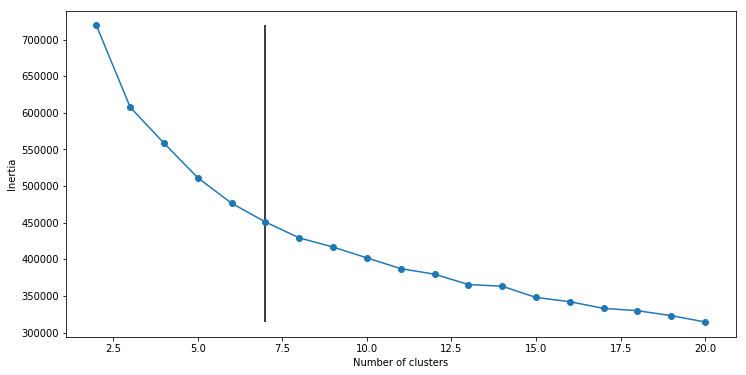

In [8]:
create_elbow_plot(n_range, kmeans_clustering_data[1])

In [22]:
# intertias
kmeans_clustering_data[1]

[719314.3684955391,
 607647.2944911785,
 558547.2191345219,
 511322.580500911,
 476563.9315979052,
 450929.15477870975,
 429234.32392852596,
 416779.42977163894,
 401935.090470556,
 387297.2445296649,
 379702.66077811393,
 365596.0916522515,
 363270.64876698353,
 347977.27233723935,
 342164.92866500415,
 332992.82671223255,
 329882.94948188297,
 323107.39428761613,
 314466.7452766952]

In [9]:
#try without STORIES, TOTALROOMS, BEDROOMS, FULLBATHS, HALFBATHS which have entries < -1
new_parcel_df = parcel_df.copy()
new_parcel_df = new_parcel_df.drop(columns=['STORIES', 'TOTALROOMS', 'BEDROOMS', 'FULLBATHS', 'HALFBATHS'])

In [10]:
kmeans_clustering_data_2 = run_kmeans_clustering(new_parcel_df)


K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   labels  frequency
0       0      68677
1       1      74988

average_silhouette_score:  0.26145026202329275
-----------------------------------------------------



K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   labels  frequency
0       0     145735
1       1     120651
2       2      20944

average_silhouette_score:  0.31589480241041895
-----------------------------------------------------



K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   labels  frequency
0       0   

average_silhouette_score:  0.6528290959015655
-----------------------------------------------------



K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
    labels  frequency
0        0     493363
1        1     540637
2        2     296429
3        3     243901
4        4     188663
5        5     135929
6        6     129414
7        7      88489
8        8      93874
9        9      69409
10      10      38702
11      11      35260
12      12      25594
13      13      22182
14      14      16326
15      15      14879
16      16       6373
17      17       2881

average_silhouette_score:  0.6336987441159615
-----------------------------------------------------



K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=19, n_init=10, n_jobs=None, precompute_distances='auto',
       random_st

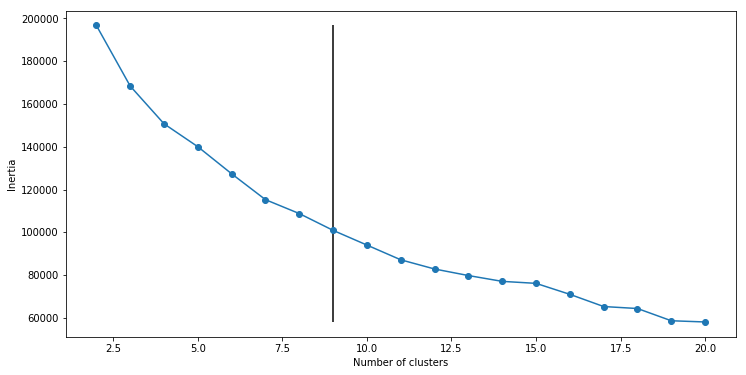

In [11]:
create_elbow_plot(n_range, kmeans_clustering_data_2[1])

In [21]:
# intertias
kmeans_clustering_data_2[1]

[196723.45794432866,
 168391.95091822458,
 150749.13381281457,
 140024.38333111326,
 127363.08843030916,
 115269.12602460037,
 108770.39007915325,
 100911.16432525039,
 94038.47414996561,
 87153.01134514285,
 82847.85212529622,
 79787.83632609739,
 77066.96222329959,
 76135.06679022139,
 71001.12295865343,
 65297.671173352726,
 64368.866008369194,
 58649.666627364524,
 58078.64810643008]

In [12]:
# Run full attribute data with k of 7 and create export csv
k7means = KMeans(init='k-means++', n_clusters=7)
clusters_k7 = k7means.fit_predict(parcel_df)

parcels_w_clusters = parcel_df.copy()
parcels_w_clusters['cluster_assignment'] = clusters_k7
today = date.today().isoformat()
export_file_name = "k7_cluster_assignment_for_parcels_{}.csv".format(today)
parcels_w_clusters.to_csv(export_file_name)

In [24]:
k8_means = KMeans(init='k-means++', n_clusters=8)
clusters_k8 = k8_means.fit_predict(new_parcel_df)

parcels_w_clusters = new_parcel_df.copy()
parcels_w_clusters['cluster_assignment'] = clusters_k8
today = date.today().isoformat()
export_file_name = "k8_cluster_assignment_for_parcels_{}.csv".format(today)
parcels_w_clusters.to_csv(export_file_name)

In [25]:
parcels_w_clusters.head(3)

,CONDO HR,MULTI-FAMILY,ROW END,ROW INTERIOR,OLD STYLE,SEMI DETACHED,CONDO,BI-LEVEL,SPLIT LEVEL,COLONIAL,TOWNHOUSE,CONDO CONV,CONDO INT,TUDOR,VICTORIAN,RANCH,CONDO GRDN,CONDO END,CAPE COD,BUNGALOW,CONTEMPORARY,MANUFACTURED,MODULAR HOME,LOG CABIN,CONDO PAT/CARG,CONVENTIONAL,OTHER,CONDO SINGLE,ROLL,SHINGLE,RUBBER,SLATE,TILE,METAL,Concrete,Brick,Stone,Concrete Block,Masonry FRAME,Frame,Stucco,Log,None,Part,Full,Slab/Piers,Crawl,cluster_assignment
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
